# Self check list for markers
#### 1. The clear step-by-step instruction on how to produce the final submit file is provided.
:)
#### 2. Code has comments and meaningful function names
:)
#### 3. For non-tree-based models preprocessing is used or the absence of it is explained
All first layer models are tree based, according to the lecture, the extreme value and outlier will not affect the result, so no outlier treatment is used.
#### 4. Features from text are extracted
Yes, city name, product type etc is used. (Section 3.1), also TF-iDF is considered (Section 3.4)
#### 5. Features extracted from text are preprocessed (with TF-iDF, stemming or lemmatization). Consider tuning of max_df and min_df parameters in sklearn's CountVectorizer as text preprocessing.
TF-iDf (Section 3.4)
#### 6. Several interesting observations about data are discovered and explained. This may be visualization of a target distribution, analysis of a time trend in data or investigation which led to a new feature creation.
See Section 2, some plots about sales count and time periods, for Oct to Dec, the sales in general is higher, so it is good to add calendar month as a feature. Rolling mean (moving averages), calendar day of that month etc
#### 7. Time-based split is used to create validation
For train/test split, it is a time series split, 0-32rd period for train, 33 is val, 34 for test. 
#### 8. Type of public/private split is identified to be random-based
Type of public/private split is identified : Should be random split, they are all in the same time period
#### 9. Final solution optimized for RMSE
Used MSE, which should be equivalent to RMSE.
#### 10. At least one mean-encoded feature is constructed
Mean encoded Item_categories and product types cities, item_id etc.
#### 11. Mean-encoding is set up correctly, i.e. KFold or expanding mean methods are utilized
:)
#### 12. At least one feature from "Advanced Features II" is utilized (Statistics and distance-based features, Matrix factorizations, Feature interactions, t-SNE)
Yes, max/min, moving average statistics (Section 3.2)
#### 13. Hyperparameters of at least half of all models are not default
Yes, in section 4.1
#### 14. Ensembling is utilized (linear combination counts)
2 layers Ensemble, first layer with XGBoost, Catboost, LGBM and randomforest, second with Linear regression (Section 4.1)
#### 15. Correct validation scheme for ensembling is utilized (KFold or Holdout, for correction assessment please review the topic about Ensembles)
Holdout is used, month 33 is heldout for ensembling testing.
#### 16. Models from different classes are utilized (at least two from the following: KNN, linear models, RF, GBDT, NN)
2 layers Ensemble, first layer with XGBoost, Catboost, LGBM and randomforest, second with Linear regression (Section 4.1)

# 0. Packages version

Here, we will first import all the packages we needed and list the verion of the packages.<br>
 
numpy 1.17.2<br>
pandas 0.24.2<br>
sklearn 0.20.3<br>
matplotlib 3.0.3<br>
xgboost 0.90 <br>
catboost 0.18 <br>
lightgbm 2.3.0

In [41]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
import catboost
import pickle


# 1. Import Data And Simple Analysis

First, we import both train and test data and compare the distribution of two datasets. <br>
The train dataset consists of 33 months.<br>
The target is to use them to predict the sales of each shops in the 34th months.

In [3]:
train = pd.read_csv('sales_train.csv.gz')
test = pd.read_csv('test.csv.gz')
shop_info = pd.read_csv('shops.csv')
item_info = pd.read_csv('items.csv')
item_cat_info = pd.read_csv('item_categories.csv')

In [4]:
print(train.columns)
print(test.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
Index(['ID', 'shop_id', 'item_id'], dtype='object')


First, we see that for the shop name, shop with id (0 and 57), (1 and 58) and (10,11) are similar and after some finding on the internet (since I dont know Russian) , they are in fact the same shop

In [5]:
shop_info.loc[0,:] = shop_info.loc[57,:]
shop_info.loc[1,:] = shop_info.loc[58,:]
shop_info.loc[10,:] = shop_info.loc[11,:]
shop_info.drop_duplicates(inplace=True)

In [8]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

The first question pops up in my mind is that:<br>
Does every shop in test set appears in the train data set? <br>
If not, we will have to interpolate the sales by other methods.

In [9]:
train['shop_id'].value_counts().sort_index().tail()

55     34769
56     69573
57    127285
58     77119
59     42108
Name: shop_id, dtype: int64

In [10]:
test['shop_id'].value_counts().sort_index().tail()

55    5100
56    5100
57    5100
58    5100
59    5100
Name: shop_id, dtype: int64

We know that:<br>
range of shop_id in train set: 2 - 59 (except 10) <br>
range of shop_id in test set: 2 - 59 (except 10) <br>

On the other hand, in reality, we know that not all shops have the all type of goods. That is, some item_id may not exist for some shops. This may be a hint for potential data leakage.

In [11]:
target_item = set(test.item_id)
target_shop = set(test.shop_id)
id_not_exist = {}
for shop in target_shop:
    id_not_exist[shop] = list(target_item - set(train[train['shop_id'] ==shop].item_id))

We Can see that there is a lot of item that did not record any sales in certain shop. So we will set the prediction for those (shop_id, item_id) pair to 0.

In [12]:
leakage_ans = pd.DataFrame(columns=['shop_id', 'item_id'])
for shop in id_not_exist.keys():
    items = id_not_exist[shop]
    leakage_ans = leakage_ans.append(pd.DataFrame({'shop_id': [shop] * len(items), 'item_id' :items}))

As the data set is a time series, we will use the 20th to 31st month to predict 32nd month as the training period. <br>
Later, we will use 21st to 32nd month to predict 33rd month as the validation period.

In [13]:
train['month'] = (train['date_block_num'] + 1) % 12

In [22]:
y_train_split = train[train['date_block_num'] == 32]
y_train_split = y_train_split.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
y_train_split.columns = ['shop_id', 'item_id', 'item_cnt_month']

train_set = train[(train['date_block_num'] > 19) & (train['date_block_num'] < 32)]
train_split = train_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
train_split = train_split.merge(train_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].min(),
                                left_on=['date_block_num', 'shop_id', 'item_id'],
                                right_index=True)

train_split = train_split.merge(item_info[['item_id', 'item_category_id']], left_on='item_id', right_on='item_id')
train_split.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price', 'item_category_id']

We now have a dataframe records the number of sales for each product in each shop per month, with the name 'item_cnt_month'. <br>
According to the instruction of the project, the target variables of the test set are integers ranging from 0 to 20, so we will clip the item_cnt_month to 20.

In [23]:
train_split['item_cnt_month'] = train_split['item_cnt_month'].clip(0,20)

# 2. EDA

In the previous section, we can see that each shop_id appears 5100 times in the test set. We believe that the item_id in the test set is in fact a set of number that repeatedly appears 58 times. Therefore, it seems that it is interesting to mean encode the item_cnt_day of each item_id/item_category_id and shop_id to help the prediction.

Therefore, we now conduct EDA to see what feature we can generate.

It seems that there is quite a strong seasonal effect for the sales, especially you can see two spikes for every december. We may include past 12 month data to capture the seasonal effect.

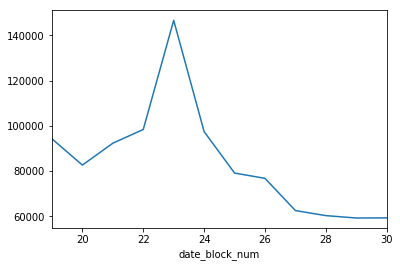

In [24]:
train_split.groupby('date_block_num')['item_cnt_month'].sum().plot()

Secondly, we can see that for different categories, the total item_cnt_month is different, indicating that some categories are much more popular then other. <br>
Moreover, the patterns for the item_cnt_month of different categories are similar across different months.<br>
This mean that we can mean encode item_category_id by the item_cnt_month.


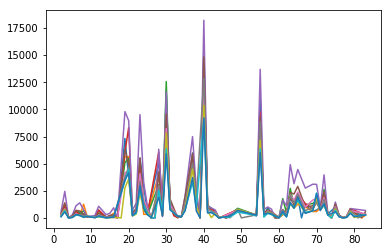

In [25]:
for i in range(19,30):
    plt.plot(train_split[train_split['date_block_num'] == i].groupby(['item_category_id'])['item_cnt_month'].sum())
plt.show()

# 3.  Feature engineering

The feature enginnering process is quite tedious, I will just select some of those to discuss. The full engineering process is packed into functions in Section 4.

### 3.1 Grouping categories

On the other hand, I can see that the item category names have a lot of common words, for example: category_id 1 to 7 starts with 'Аксессуары' which I think it can let me group the items to bigger categories.

In [26]:
item_cat_info['item_category_name'][1:8]

1         Аксессуары - PS2
2         Аксессуары - PS3
3         Аксессуары - PS4
4         Аксессуары - PSP
5      Аксессуары - PSVita
6    Аксессуары - XBOX 360
7    Аксессуары - XBOX ONE
Name: item_category_name, dtype: object

In [27]:
item_cat_info['bigger_cat'] = item_cat_info['item_category_name'].str.split('-').apply(lambda x:x[0])
item_cat_info['bigger_cat'] = LabelEncoder().fit_transform(item_cat_info['bigger_cat'])

train_split = train_split.merge(item_cat_info[['item_category_id','bigger_cat']], left_on='item_category_id', right_on='item_category_id')

Similar for the suffix of the item_category_name, we see PS2, PSP etc repeat several time, we can also use those suffixies as another categorical features

### 3.2 Adding time series statistics

Since we believe that if the item_price drops after a period, then the product may be outdated and not popular at all. Which will mean that the future item_cnt_day decrease. So we create features about item_price changes.

In [28]:
#pivot table to have a series of number of sales count per month for each (item,shop) pair
train_for_fit = train_split.pivot_table(values='item_cnt_month', index=['item_id','shop_id'], columns=['date_block_num'], aggfunc=np.mean).fillna(0)
train_for_fit.columns = ['past_block_'+ str(12 - i) for i in range(0,12)]
pivoted_item_count = train_for_fit.copy()
#create 3 month moving average of the sales count 
rolling_mean3m = pivoted_item_count.rolling(3,axis=1).mean().dropna(axis=1)
rolling_mean3m.columns = ['past_block_3m_mean_'+ str(10 - i) for i in range(0,10)]
train_for_fit = train_for_fit.merge(rolling_mean3m, left_index=True, right_index=True)
# create min, max, mean 
train_for_fit['max_item_cnt_month'] = pivoted_item_count.max(axis=1)
train_for_fit['min_item_cnt_month'] = pivoted_item_count.min(axis=1)
train_for_fit['mean_item_cnt_month'] = pivoted_item_count.mean(axis=1)

The same process is done for generate average category month sales for shop_id, item_id, item_category_id, bigger_cat

### 3.3 Stacking different time periods

Here, we deal with the features in 20th to 31st month and use that to predict 32nd months' sales figure. <br>
we can also append the same set of features form 19th to 30th month to predict 31st months' sales month and so on,
so as to augment the training set and capture the effect of different calender month. This will be done using a function followed by a for loop.

### 3.4 Text features

In [42]:
word_processor = TfidfVectorizer()
word_processor.fit(item_cat_info['item_category_name'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [43]:
text_features = pd.DataFrame(word_processor.transform(item_cat_info['item_category_name']).todense(),
                             columns=word_processor.get_feature_names())

# 4.Building Model

The function belows are just a pipeline to replicate all the feature engineering above, so that we can perform the same process for train, validation and test set. 

In [ ]:
def data_preprocess(i, train):
    # Generate categorical features for item categories and city
    item_cat_info['bigger_cat1'] = item_cat_info['item_category_name'].str.split('-').apply(lambda x:x[0])
    item_cat_info['bigger_cat2'] = item_cat_info['item_category_name'].str.split('-').apply(lambda x:x[-1])
    item_cat_info['bigger_cat1'] = LabelEncoder().fit_transform(item_cat_info['bigger_cat1'])
    item_cat_info['bigger_cat2'] = LabelEncoder().fit_transform(item_cat_info['bigger_cat2'])
    shop_info['city'] = shop_info['shop_name'].str.split(' ').apply(lambda x:x[0])
    shop_info['city'] = LabelEncoder().fit_transform(shop_info['city'])
    
    if i == 'train':
        y_split = train[train['date_block_num'] == 32]
        X_set = train[(train['date_block_num'] >= 20) & (train['date_block_num'] < 32)]
        y_split = y_split.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
        y_split.columns = ['shop_id', 'item_id', 'item_cnt_month']
    elif i == 'val' : 
        y_split = train[train['date_block_num'] == 33]
        X_set = train[(train['date_block_num'] >= 21) & (train['date_block_num'] < 33)]
        y_split = y_split.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
        y_split.columns = ['shop_id', 'item_id', 'item_cnt_month']
    elif i == 'test' :
        X_set = train[(train['date_block_num'] >= 22)]
        y_split = None
    elif i in range(1,20):
        y_split = train[train['date_block_num'] == i+13]
        X_set = train[(train['date_block_num'] > i) & (train['date_block_num'] < (i+13))]
        y_split = y_split.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
        y_split.columns = ['shop_id', 'item_id', 'item_cnt_month']
    else :
        raise ValueError('i can only be train, val, test or int form 1 to 19!!!')
    
    # merging all information to a sigle dataframe and aggregate the item sales to monthly form 
    X_split = X_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
    
    X_split = X_split.merge(X_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].min(),
                                    left_on=['date_block_num', 'shop_id', 'item_id'],
                                    right_index=True)

    X_split = X_split.merge(item_info[['item_id', 'item_category_id']], left_on='item_id', right_on='item_id')
    X_split = X_split.merge(item_cat_info[['item_category_id', 'bigger_cat1', 'bigger_cat2']],
                            left_on='item_category_id',
                            right_on='item_category_id')
    X_split = X_split.merge(shop_info[['city', 'shop_id']], left_on='shop_id', right_on='shop_id')
    
    X_split.columns = ['date_block_num', 
                       'shop_id', 
                       'item_id', 
                       'item_cnt_month', 
                       'item_price', 
                       'item_category_id', 
                       'bigger_cat1', 
                       'bigger_cat2',
                       'city']
    
    #Clip the target to 20    
    X_split['item_cnt_month'] = X_split['item_cnt_month'].clip(0,20)
    
    return X_split, y_split

def feature_engineering(X_split, i):
    # pivot the table to have a series of number of sales count per month for each (item,shop) pair
    pivoted_item_shop_count = X_split.pivot_table(values='item_cnt_month', index=['item_id','shop_id'], columns='date_block_num', aggfunc=np.mean).fillna(0)
    item_cat_info['bigger_cat1'] = item_cat_info['item_category_name'].str.split('-').apply(lambda x:x[0])
    item_cat_info['bigger_cat2'] = item_cat_info['item_category_name'].str.split('-').apply(lambda x:x[-1])
    item_cat_info['bigger_cat1'] = LabelEncoder().fit_transform(item_cat_info['bigger_cat1'])
    item_cat_info['bigger_cat2'] = LabelEncoder().fit_transform(item_cat_info['bigger_cat2'])
    shop_info['city'] = shop_info['shop_name'].str.split(' ').apply(lambda x:x[0])
    shop_info['city'] = LabelEncoder().fit_transform(shop_info['city'])
    
    #merge the city and categorical information to single dataframe
    X_for_fit = pivoted_item_shop_count.copy()
    X_for_fit.columns = ['item_cnt_past_block_'+ str(i) for i in range(0, 12)]
    X_for_fit = X_for_fit.reset_index()
    X_for_fit = X_for_fit.merge(item_info[['item_id','item_category_id']], left_on='item_id', right_on='item_id')
    X_for_fit = X_for_fit.merge(item_cat_info[['bigger_cat1', 'bigger_cat2', 'item_category_id']], left_on='item_category_id', right_on='item_category_id')
    X_for_fit = X_for_fit.merge(shop_info[['city', 'shop_id']], left_on='shop_id', right_on='shop_id')
    
    pivoted_item_shop_count = pivoted_item_shop_count.reset_index(drop=True)
    
    #create 3 month moving average of the sales count
    rolling_mean3m = pivoted_item_shop_count.rolling(3, axis=1).mean().dropna(axis=1)
    rolling_mean3m.columns = ['item_shop_past_block_3m_mean_'+ str(i) for i in range(0, 10)]
    X_for_fit = X_for_fit.merge(rolling_mean3m, left_index=True, right_index=True)
    
    #create 6 month moving average of the sales count
    rolling_mean6m = pivoted_item_shop_count.rolling(6, axis=1).mean().dropna(axis=1)
    rolling_mean6m.columns = ['item_shop_past_block_6m_mean_'+ str(i) for i in range(0, 7)]
    rolling_mean6m = rolling_mean6m.reset_index()
    X_for_fit = X_for_fit.merge(rolling_mean6m, left_index=True, right_index=True)
    
    #create 12 month moving average of the sales count
    rolling_mean12m = pivoted_item_shop_count.rolling(12, axis=1).mean().dropna(axis=1)
    rolling_mean12m.columns = ['item_shop_past_block_12m_mean_'+ str(i) for i in range(0, 1)]
    rolling_mean12m = rolling_mean12m.reset_index()
    X_for_fit = X_for_fit.merge(rolling_mean12m, left_index=True, right_index=True)
    
    #create min, max, mean 

    X_for_fit['item_shop_max'] = pivoted_item_shop_count.max(axis=1)
    X_for_fit['item_shop_min'] = pivoted_item_shop_count.min(axis=1)
    X_for_fit['item_shop_mean'] = pivoted_item_shop_count.mean(axis=1)


    for feature in ['shop_id', 'item_category_id', 'bigger_cat1', 'bigger_cat2', 'city']:
        pivoted_count = X_split.pivot_table(values='item_cnt_month', index=feature, columns ='date_block_num', aggfunc=np.mean).fillna(0)
        pivoted_count.columns = ['item_' + feature + '_past_block_'+ str(i) for i in range(0, 12)]
        
        #mean encode the categorical features by rolling means, max and min
        rolling_mean3m = pivoted_count.rolling(3,axis=1).mean().dropna(axis=1)
        rolling_mean3m.columns = ['item_' + feature + '_past_block3m_mean_'+ str(i) for i in range(0, 10)]
        X_for_fit = X_for_fit.merge(rolling_mean3m, left_on=feature, right_index=True)
                       
        rolling_mean6m = pivoted_count.rolling(6,axis=1).mean().dropna(axis=1)
        rolling_mean6m.columns = ['item_' + feature + '_past_block6m_mean_'+ str(i) for i in range(0, 7)]
        X_for_fit = X_for_fit.merge(rolling_mean6m, left_on=feature, right_index=True)

        rolling_mean12m = pivoted_count.rolling(12,axis=1).mean().dropna(axis=1)
        rolling_mean12m.columns = ['item_' + feature + '_past_block12m_mean_'+ str(i) for i in range(0, 1)]
        X_for_fit = X_for_fit.merge(rolling_mean12m, left_on=feature, right_index=True)

        X_for_fit['max_' + feature + '_cnt_month'] = X_for_fit[feature].map(pivoted_count.max(axis=1))
        X_for_fit['min_' + feature + '_cnt_month'] = X_for_fit[feature].map(pivoted_count.min(axis=1))
        X_for_fit['mean_' + feature + '_cnt_month'] = X_for_fit[feature].map(pivoted_count.mean(axis=1))
        

    X_for_fit['calendar_month'] = i % 12 + 1
    days_of_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    X_for_fit['num_days'] = days_of_month[ (i-1) % 12 + 1]
    return X_for_fit

def merge_before_fit(X_for_fit, y_for_fit):
    X = X_for_fit.drop(['item_category_id'], axis=1)
    y = y_for_fit
    full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'], how='left').fillna(0)
    X_train = full_data.drop(['shop_id', 'item_id', 'item_cnt_month', 'bigger_cat1', 'bigger_cat2', 'city'], axis=1)
    X_train = full_data.drop(['item_cnt_month'], axis=1)
    y_train = full_data['item_cnt_month']
    y_train = y_train.clip(0,20)
    return X_train, y_train

In [ ]:
# we want to use all the time periods, so to stack the model for all time period 
X_train, y_train = data_preprocess('train', train) 
X_train = feature_engineering(X_train, 20)
X_train, y_train = merge_before_fit(X_train, y_train)
# for i in range(1,20):
#     X_temp, y_temp = data_preprocess(i, train) 
#     X_temp = feature_engineering(X_temp, i)
#     X_temp, y_temp = merge_before_fit(X_temp, y_temp)
#     X_train = X_train.append(X_temp)
#     y_train = y_train.append(y_temp)

In [ ]:
X_val, y_val = data_preprocess('val', train) 
X_val = feature_engineering(X_val, 21)
X_val, y_val = merge_before_fit(X_val, y_val)

In [ ]:
n_estimators_xgb = np.random.choice(np.arange(100, 1000))
max_depth_xgb = np.random.choice(np.arange(1, 11))
reg_lambda_xgb = np.random.choice(np.arange(0, 2, 0.01))
reg_alpha_xgb = np.random.choice(np.arange(0, 2, 0.01))
learning_rate_xgb = np.random.choice(np.arange(0.1, 0.5,0.01))
print(n_estimators_xgb,
max_depth_xgb,
reg_lambda_xgb,
reg_alpha_xgb,
learning_rate_xgb)

In [ ]:
model1 = xgb.XGBRegressor(n_estimators=n_estimators_xgb,
                          max_depth=max_depth_xgb,
                          learning_rate=learning_rate_xgb,
                          reg_lambda = reg_lambda_xgb,
                          reg_alpha = reg_alpha_xgb,
                          n_jobs=-1,
                          random_state=9,
                          objective='reg:squarederror')
model1.fit(X_train, y_train)
output1 = model1.predict(X_train)
print(np.sqrt(mean_squared_error(y_train, output1)))
print(np.sqrt(mean_squared_error(y_val, model1.predict(X_val))))

### 4.1 Feature Selection and hyperparameter tuning

Select feature with importance >0 so as to reduce the size of feature and make the hyperparameter search faster.

In [ ]:
importance = pd.Series(model1.feature_importances_, X_train.columns)
important_features = list(importance[importance>0].index)
importance.sort_values()

In [ ]:
# Choosing hyperparameter
for i in range(1,10):
    # random parameter
    print('trial: ' + str(i))
    n_estimators_xgb = np.random.choice(np.arange(10, 100))
    max_depth_xgb = np.random.choice(np.arange(5, 14))
    reg_lambda_xgb = np.random.choice(np.arange(0, 2, 0.01))
    reg_alpha_xgb = np.random.choice(np.arange(0, 2, 0.01))
    learning_rate_xgb = np.random.choice(np.arange(0.1, 0.5, 0.01))
    n_estimators_rf = np.random.choice(np.arange(100, 500))
    max_depth_rf = np.random.choice(np.arange(1, 11))
    eta_catboost = np.random.choice(np.arange(0.01, 0.3, 0.01))
    max_depth_catboost = np.random.choice(np.arange(5, 14))
    eta_lgbm = np.random.choice(np.arange(0.01, 0.3, 0.01))
    max_depth_lgbm = np.random.choice(np.arange(5, 14))
    alpha_lasso = np.random.choice(np.arange(0.01, 0.3, 0.01))
    
    print(n_estimators_xgb,
    max_depth_xgb,
    reg_lambda_xgb,
    reg_alpha_xgb,
    learning_rate_xgb,
    n_estimators_rf,
    max_depth_rf,
    eta_catboost,
    max_depth_catboost,
    eta_lgbm,
    max_depth_lgbm,
    alpha_lasso)

    #Layer 1, XGB, Randomforest, catboost and lightgbm
    model1 = xgb.XGBRegressor(n_estimators=n_estimators_xgb,
                              max_depth=max_depth_xgb,
                              learning_rate=learning_rate_xgb,
                              reg_lambda = reg_lambda_xgb,
                              reg_alpha = reg_alpha_xgb,
                              n_jobs=-1,
                              random_state=9,
                              objective='reg:squarederror')
    
    model1.fit(X_train[important_features], y_train)
    output1 = model1.predict(X_train[important_features])
    
    model2 = RandomForestRegressor(n_estimators=n_estimators_rf,
                                   max_depth=max_depth_rf,
                                   random_state=9,
                                   n_jobs=-1)
    model2.fit(X_train[important_features], y_train)
    output2 = model2.predict(X_train[important_features])
    
    model4 = catboost.CatBoostRegressor(learning_rate=eta_catboost, depth=max_depth_catboost)
    model4.fit(X_train[important_features],y_train)
    output4 = model4.predict(X_train[important_features])
    
    model5 = LGBMRegressor(max_depth=max_depth_lgbm, learning_rate=eta_lgbm)
    model5.fit(X_train[important_features], y_train)
    output5 = model5.predict(X_train[important_features])
    
    input_layer2=np.c_[output1, output2, output4, output5]
    model6 = Lasso(alpha_lasso)
    model6.fit(input_layer2, y_train)
    print('train model r2 score: ' + str(r2_score(y_train, model6.predict(input_layer2))))
    print('train rmse score: ' + str(np.sqrt(mean_squared_error(y_train, model6.predict(input_layer2)))))
    
    #layer2: linear regression
    #I ensembled the all outputs of the first layer and by linear regression 
    output1 = model1.predict(X_val[important_features])
    output2 = model2.predict(X_val[important_features])
    output4 = model4.predict(X_val[important_features])
    output5 = model5.predict(X_val[important_features])
    input_layer2=np.c_[output1, output2, output4, output5]
    
    output6 = model6.predict(input_layer2)
    print('val model r2 score: ' + str(r2_score(y_val, model6.predict(input_layer2))))
    print('val rmse r2 score: ' + str(np.sqrt(mean_squared_error(y_val, model6.predict(input_layer2)))))

## Refit the model with val set

In [ ]:
# append the last validation period to the training set
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

In [ ]:
#Layer 1, XGB, Randomforest, catboost and lightgbm
model1 = xgb.XGBRegressor(n_estimators=13,
                          max_depth=12,
                          learning_rate=0.17,
                          reg_lambda = 1.33,
                          reg_alpha = 0.29,
                          n_jobs=-1,
                          random_state=9,
                          objective='reg:squarederror')

model1.fit(X_train[important_features], y_train)
output1 = model1.predict(X_train[important_features])

model2 = RandomForestRegressor(n_estimators=103,
                               max_depth=13,
                               random_state=9,
                               n_jobs=-1)
model2.fit(X_train[important_features], y_train)
output2 = model2.predict(X_train[important_features])

model4 = model4 = catboost.CatBoostRegressor(learning_rate=0.23, depth=9)
model4.fit(X_train[important_features],y_train)
output4 = model4.predict(X_train[important_features])

model5 = LGBMRegressor(max_depth=7, learning_rate=0.21)
model5.fit(X_train[important_features], y_train)
output5 = model5.predict(X_train[important_features])

#layer2: linear regression
#I ensembled the all outputs of the first layer and by linear regression 
input_layer2=np.c_[output1, output2, output4, output5]
model6 = Lasso(0.02)
model6.fit(input_layer2, y_train)
print('train model r2 score: ' + str(r2_score(y_train, model6.predict(input_layer2))))
print('train rmse score: ' + str(np.sqrt(mean_squared_error(y_train, model6.predict(input_layer2)))))


# 5. Predicting test set and submit

In [ ]:
#Output the dataset
X_test, y_test = data_preprocess('test', train) 
X_split = feature_engineering(X_test,22)

In [ ]:
models = {'XGB':model1, 'RF':model2, 
          'Catboost':model4, 
          'LGBM':model5, 'LR':model6, 
          'features':important_features, 'data':X_split}
with open('model_and_data.pkl','wb') as port:
    pickle.dump(models, port)

In [ ]:
with open('model_and_data.pkl','rb') as port:
    models = pickle.load(port)
model1 = models['XGB']
model2 = models['RF']
model4 = models['Catboost']
model5 = models['LGBM']
model6 = models['LR']
X_split = models['data']
important_features = models['features']

In [ ]:
output1 = model1.predict(X_split[important_features])
output2 = model2.predict(X_split[important_features])
output4 = model4.predict(X_split[important_features])
output5 = model5.predict(X_split[important_features])
input_layer2=np.c_[output1, output2, output4, output5]
#layer2: linear regression
#I ensembled the all outputs of the first layer and by linear regression 
output6 = model6.predict(input_layer2)

In [ ]:
X_split['item_cnt_month'] = output6

In [ ]:
test = test.merge(X_split[['item_id', 'shop_id', 'item_cnt_month']],
                  left_on=['item_id', 'shop_id'],
                  right_on= ['item_id', 'shop_id'],
                  how='left')
#fill those NA as 0
result = test[['ID', 'item_cnt_month']].fillna(0).clip(0,20)

result.to_csv('submission.csv', index=False)